In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
# Import models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# Import model comparison metrics
from sklearn.metrics import mean_squared_error, auc, r2_score

In [4]:
# Import dataset

df = pd.read_csv('candy-data.csv')

In [5]:
df_clustering = df
df_regression = df.drop(columns= ['competitorname'])

In [6]:
# List of independent variables
characteristics = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']

<b> Clustering Analysis </b>

1. From the EDA, we realized that chocolate is a must have component for the new candy
2. fruity and chocolate do not got together
3. The candies at the bottom of the winpercent table are almost all 'pluribus' i.e. appearing as small candies in a packet
4. There are no hard candies in top performing candies
5. There are almost no bars in the bottom performing candies, but candies which are have 'bar' characteristic do appear in the top performing candies

Therefore, we drop columns --> 'sugarpercent', 'pricepercent' for the purpose of our analysis

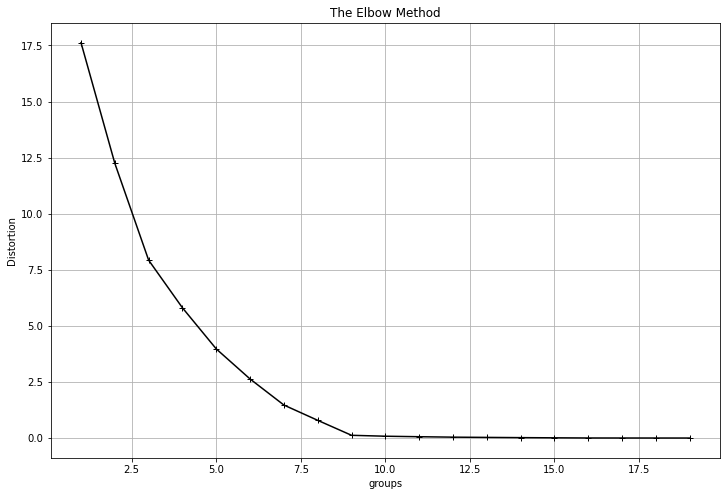

In [7]:
# K means clustering to find main combinations
k_labels = ['caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'winpercent']

df_clustering = df_clustering.drop(['competitorname', 'sugarpercent', 'pricepercent'],axis=1)

df_clustering = df_clustering[(df_clustering['chocolate'] == 1) & (df_clustering['bar'] == 1) & (df_clustering['fruity'] == 0)]
df_clustering = df_clustering[k_labels]
df_clustering['winpercent'] = df_clustering['winpercent']/100  # scale to fit categorical data distances

df_KMeans = df_clustering

## unique candy classes
unique_candy_classes = len(df_KMeans.drop_duplicates())

## elbow method
distortions = []
K = range(1,unique_candy_classes)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_KMeans)
    distortions.append(kmeanModel.inertia_)


# graphics
fig = plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.plot(K, distortions, '+-', color='black')
plt.xlabel('groups'); plt.ylabel('Distortion'); plt.grid(True)


plt.show()

according to the above graph, k = 9 is the ideal value

In [8]:
kmeanModel = KMeans(n_clusters=9)
kmeanModel.fit(df_KMeans)

df = pd.DataFrame (data=np.round(kmeanModel.cluster_centers_, 3), columns=k_labels)
df['winpercent'] = df['winpercent']*100  # unscale winpercent to range 0-100
print ('Main Candy subgroups\n')
df.sort_values('winpercent', ascending=False)

Main Candy subgroups



,caramel,peanutyalmondy,nougat,crispedricewafer,winpercent
6,1.0,0.0,0.0,1.0,74.3
0,0.0,0.0,0.0,1.0,68.5
1,1.0,0.0,1.0,0.0,67.0
5,1.0,1.0,1.0,0.0,66.8
8,1.0,0.0,0.0,0.0,64.4
4,1.0,1.0,0.0,1.0,59.5
2,0.0,1.0,0.0,0.0,58.5
3,0.0,0.0,0.0,0.0,53.3
7,0.0,0.0,1.0,0.0,53.3


According the k-means clustering, the best ingredients to build mixed chocolate-bar are:
1. caramel
2. crispedricewafer
3. peanutyalmondy

<b> Regression Analysis </b>

In [9]:
X = df_regression.drop(['winpercent', 'sugarpercent', 'pricepercent'], axis=1)
y = df_regression['winpercent']


In [10]:
X.shape

(85, 9)

In [11]:
y.shape

(85,)

In [12]:
# linear regression for categories
linear_regression_model = LinearRegression(fit_intercept=True)
linear_regression_model.fit(X, y)

y_pred = linear_regression_model.predict(X)
score = linear_regression_model.score(X, y)
mse = mean_squared_error(y, y_pred)

coeff = pd.DataFrame(linear_regression_model.coef_, X.columns, columns=['coef']).sort_values('coef', ascending = False)
intercept  = linear_regression_model.intercept_


In [13]:
for x,y in zip(X.columns, linear_regression_model.coef_): # coefficients of features.
    print(x, y)

chocolate 19.905794550599964
fruity 10.26773158023736
caramel 3.3842817840265416
peanutyalmondy 10.141017274687082
nougat 2.416251761855696
crispedricewafer 8.991549041710035
hard -4.872560103227026
bar -0.721966255352471
pluribus -0.15991743153211088


<b> According to regression analysis, the recommendation for the new chocolate should be: </b>

1. Chocolate will increase the winpercent by approx. 20 percent.
2. peanutyalmondy will increase the winpercent by approx. 10 percent.
3. crispedricewafer will increase the winpercent by approx. 9 percent.
4. Although, fruity characteristic is high, from the EDA, we know that chocolate and fruity are negatively correlated and most of the fruity candies have pluribus characteristic rather than bar. Therefore, we do not consider fruity characteristic.

Final recommendations according to both analysis:

1. Chocolate
2. Peanut-almond-peanut_butter
3. Crisped rice wafer

Since bars are more preferable to pluribus, the candy should be in the form of a bar.